In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import regionate
import matplotlib.pyplot as plt

## 0. Loading and exploring CM4 ocean diagnostics

In [101]:
from example_dataset_grids import load_CM4p25
ds, grid = load_CM4p25("sigma2", [35, 38], z_coord="zstr")

## 1. Determine a mask for the region of interest.

In [102]:
ds['mask'] = (
    (ds['deptho'] <= 1000.) &
    (ds['geolat'] <= -57.5)
)

/vftmp/Henri.Drake/pid7355/ipykernel_9205/3776872106.py:9: UserWarning: No contour levels were found within the data range.
  plt.contour(
/vftmp/Henri.Drake/pid7355/ipykernel_9205/3776872106.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(


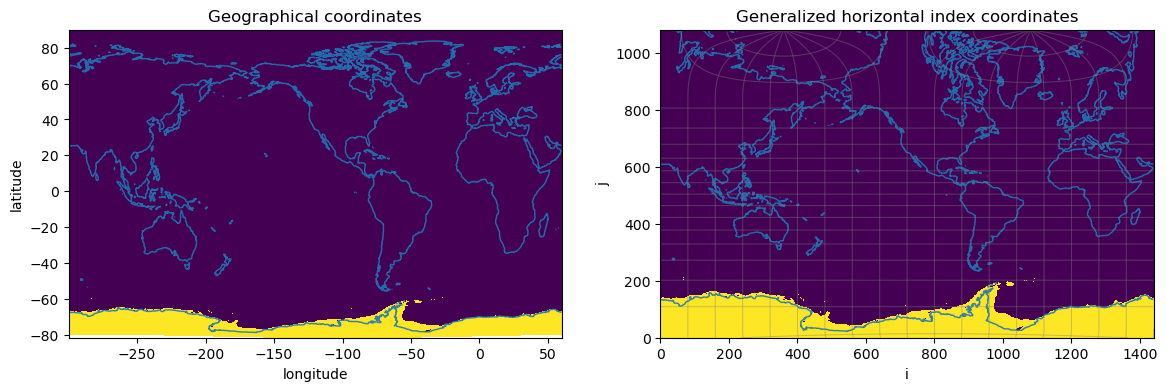

In [5]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    ds.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1,2,2)
plt.pcolor(
    ds.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");

## 2. We use `regionate` to find the sections that bound the region

On the backend, this approach uses `countourpy` to find the demical indices of the contours of the mask in index space, and then convert these into the corresponding integer indices of the ocean model's vorticity grid (corners of C-grid tracer cells). 

In [103]:
from regionate import MaskRegions, GriddedRegion
regions = MaskRegions(ds.mask, grid).regions

## 3. We pick out the key contour and ignore all of the smaller seaward islands/rises and shoreward depressions

In [104]:
antarctic = regions[0]
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

/vftmp/Henri.Drake/pid7355/ipykernel_9205/4031526429.py:9: UserWarning: No contour levels were found within the data range.
  plt.contour(
/vftmp/Henri.Drake/pid7355/ipykernel_9205/4031526429.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(


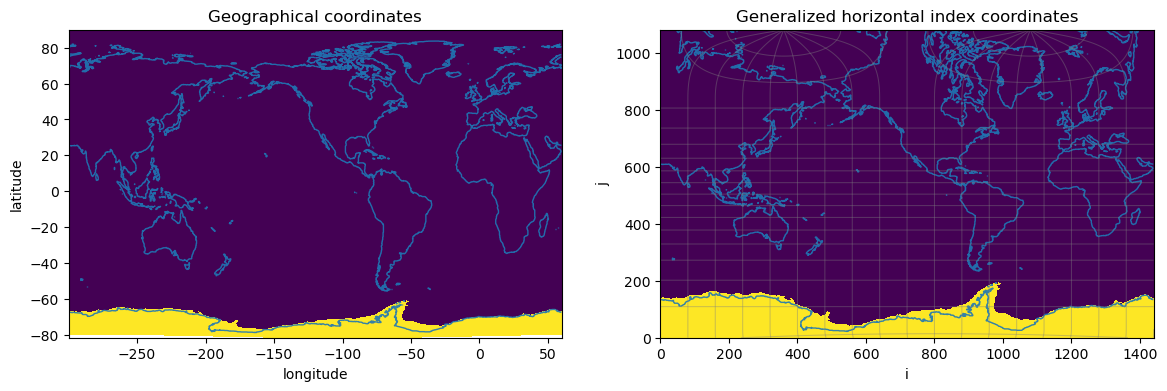

In [105]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1,2,2)
plt.pcolor(
    region.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");

### 4. We lazily evaluate the region's water mass budget, leveraging `xarray`

We identify all of the relevant budget terms by importing a `yaml` file describing the conventions for tracer budget diagnostics in MOM6

In [106]:
import yaml

with open("../conventions/MOM6.yaml", "r") as stream:
    try:
        budgets_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [109]:
import xwmb
wmb = xwmb.WaterMassBudget(
    grid,
    budgets_dict,
    region
)
toSv = -1.e-6/wmb.rho_ref # reverse sign to get transformation towards higher lower density (positive=diapycnal upwelling)

In [110]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmt = wmb.mass_budget("sigma2")

## 5. We load the key integrated water mass budget terms into memory and plot them

In [111]:
# Water Mass Transformation terms
wmt['total_tendency'].load()
wmt['advection'].load()
wmt['diffusion'].load()
wmt['external_forcing'].load()

# Overturning in density space
wmt['overturning'].load();

# Mass tendency term is missing because I could not find snapshot diagnostics for this experiment

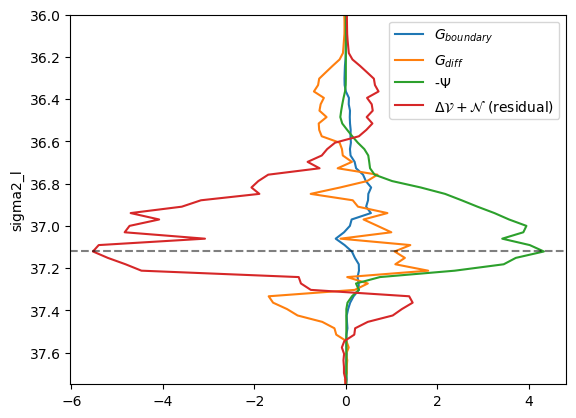

In [126]:
(wmt['external_forcing']*toSv).mean('time').plot(label=r"$G_{boundary}$", y="sigma2_l")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$G_{diff}$", y="sigma2_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"-$\Psi$", y="sigma2_l")
residual = (
    -wmt['total_tendency'] +
    wmt['advection'] +
    wmt['overturning']
)
(residual*toSv).mean('time').plot(label=r"$\Delta \mathcal{V} + \mathcal{N}$ (residual)", y="sigma2_l")

sigma2_max_overturning = wmt['overturning'].mean('time').idxmax()
plt.axhline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)

plt.ylim(37.75, 36)
plt.legend()

## 6. We decompose the transport term spatially to understand where key outflows are dense shelf water are

In [117]:
wmb.ds['convergent_mass_transport_below'].load();

/vftmp/Henri.Drake/pid7355/ipykernel_9205/3424438074.py:12: UserWarning: No contour levels were found within the data range.
  plt.contour(


(-79.0, -59.0)

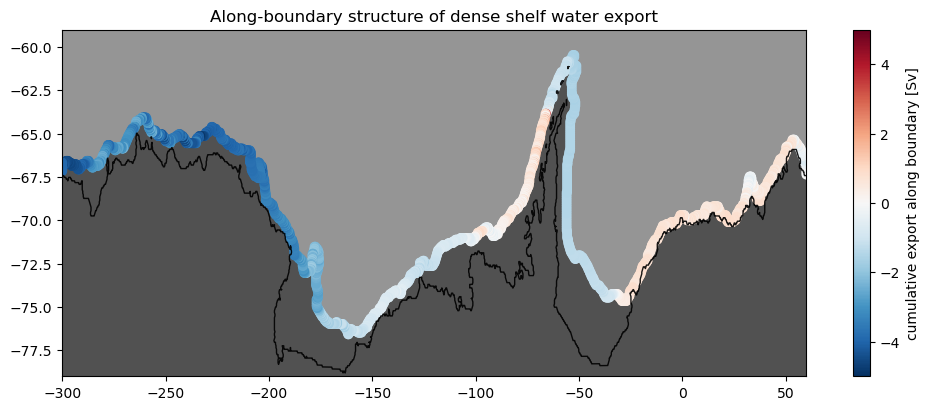

In [129]:
outflows = wmb.ds['convergent_mass_transport_below'].sel(sigma2_i=sigma2_max_overturning, method="nearest").cumsum("sect")*toSv
outflows = outflows.where((outflows!=0.) & (outflows!=outflows.isel(sect=-1)), np.nan)

plt.figure(figsize=(12, 4.5))
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=-2, vmax=2,
    cmap="Greys"
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="k",
    linewidths=1.,
    alpha=0.9
)
sc = plt.scatter(
    wmb.region.lons,
    wmb.region.lats,
    c=outflows,
    cmap="RdBu_r"
)
plt.colorbar(sc, label="cumulative export along boundary [Sv]")
plt.title("Along-boundary structure of dense shelf water export")
plt.clim(-5., 5.)
plt.xlim(-300, 60)
plt.ylim(-79, -59);